In [1]:
# Import needed libraries
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


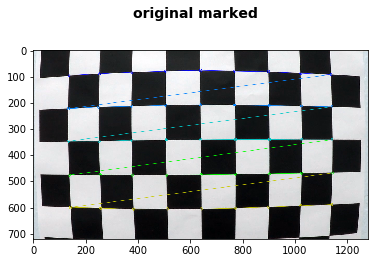

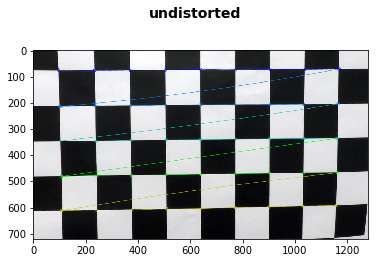

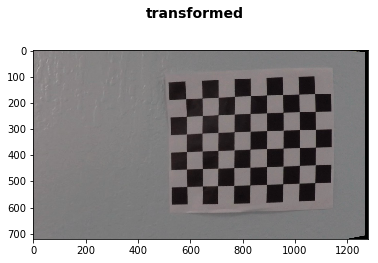

In [102]:
# Begin Pipeline

# Read in Images
os.chdir('C:\\Users\\drose\\Google Drive\\mooc\\Udacity\\sdc\\p4\\HiFi-Lane-Tracking')    
import glob
cal_images = []
for img in glob.glob("media\\camera_cal\\*.jpg"):
    n = cv2.imread(img)
    cal_images.append(n)
    
cal1  = cal_images[0]
cal2 = cal_images[3]

"""
Camera Calibration and Distortion Correction
"""
# Color conversion to Gray
def toGray(img):
    #plt.suptitle('Before', fontsize=14, fontweight='bold')
    #plt.imshow(img)
    #plt.show()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.suptitle('After Gray', fontsize=14, fontweight='bold')
    #plt.imshow(gray,cmap='gray')
    #plt.show()
    return gray

# Prepare object points

def toDist(img,nx,ny):
    objpoints = []
    imgpoints = []
    #nx, ny = 9, 5
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates
    
    # Find chessboard corners
    ret, corners= cv2.findChessboardCorners(img, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        plt.suptitle('original marked', fontsize=14, fontweight='bold')
        plt.imshow(img)
        plt.show()

        global mtx
        global dist
        global rvecs
        global tvecs
        global undist
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        plt.suptitle('undistorted', fontsize=14, fontweight='bold')
        plt.imshow(undist)
        plt.show()
    if ret == False:
        print('Did not find any corners')
        

        
def toWarp(img,src,dst,undist=undist):     
    # Grab the image shape
    img_size = (toGray(img).shape[1], toGray(img).shape[0])

    #print(np.shape(gray))
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    global warped
    warped = cv2.warpPerspective(img, M, img_size)
    plt.suptitle('transformed', fontsize=14, fontweight='bold')
    plt.imshow(warped)
    plt.show()
    #return warped

src = np.float32([[600, 140], # Top-Left
          [1200, 60], 
          [1200, 570], 
          [600, 520]])
# Destination is just filling whole frame for now
dst = np.float32([[500, 100], # Top-Left
              [1200, 60], 
              [1200, 570], 
              [500, 600]])

"""
Color/Gradient Threshold
Canary, x/y, HSL conversion, Sobel
"""
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


#abs_sobel_thresh(img, thresh_min=30, thresh_max=100)


"""
Perspective Transform
Birds Eye View
"""



"""
Begin Lane Line Detection
"""



"""
Determine Lane Curvature
"""

#toGray(cal1)

#img,nx,ny,src,dst

toDist(cal1, nx=nx,ny=ny)

toWarp(cal2, src=src,dst=dst)

In [79]:
def testt():
    global a 
    a = 4 + 4
    
testt()

a

8

In [54]:
src

array([[[  137.47563171,    96.45305634]],

       [[ 1137.7130127 ,    92.92029572]],

       [[ 1141.        ,   588.5       ]],

       [[  142.79202271,   599.25183105]]], dtype=float32)